In [493]:
import numpy as np
import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
from dfply import *
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [445]:
df = pd.read_spss('../Data/PsychiatricDiagnosisandSuicideAttempts/database_suicide_diagnosis.sav')
df[list(df.filter(regex='current').columns)] = abs(df.filter(regex='current')-1)

In [447]:
pd.options.display.max_seq_items=300
df['sSui'] = df['a51'].astype('float') + df['a53'].astype('float') #Serious Suicide Attempts
df.a54 = df.a54.replace('TOO_MANY', 'NaN')
df['nsSui'] = df['a52'].astype('float') + df['a54'].astype('float')

In [448]:
print('missing data:', sum(df.sSui.isna()))

missing data: 5


In [449]:
df.sSui = df.sSui.replace(101.0, float('NaN'))
df.sSui = df.sSui.astype('float')

In [450]:
df.nsSui.value_counts()

0.0     3248
1.0      276
2.0       73
3.0       31
5.0       11
4.0       10
8.0        6
6.0        3
9.0        2
20.0       2
15.0       1
45.0       1
10.0       1
48.0       1
16.0       1
Name: nsSui, dtype: int64

In [451]:
print('missing data:', sum(df.nsSui.isna()))

missing data: 7


In [452]:
print('Correlation between serious and non-serious suicidal attempts:', df.nsSui.corr(df.sSui))

Correlation between serious and non-serious suicidal attempts: 0.120046262150994


In [453]:
from sklearn import tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample
import graphviz 

In [454]:
#Imputation 
df4Tree = df.filter(regex='current|Sui$|SuiCut')
df4TreeComp = df4Tree.dropna()

df4TreeComp['sSuiCut'] = pd.cut(df4TreeComp.sSui,[-1,0,1,2,999])
df4TreeComp['sSuiCutBi'] = pd.cut(df4TreeComp.sSui,[-1,0,999])
df4TreeComp['nsSuinCut'] = pd.cut(df4TreeComp.nsSui,[-1,0,1,2,999])
df4TreeComp['nsSuinCutBi'] = pd.cut(df4TreeComp.nsSui,[-1,0,999])



In [455]:
df4TreeComp['sSuiCut'] = df4TreeComp['sSuiCut'].cat.rename_categories(['0','1','2','3+'])
df4TreeComp['sSuiCutBi'] = df4TreeComp['sSuiCutBi'].cat.rename_categories(['0','1'])
df4TreeComp['nsSuiCut'] = df4TreeComp['nsSuinCut'].cat.rename_categories(['0','1','2','3+'])
df4TreeComp['nsSuiCutBi'] = df4TreeComp['nsSuinCutBi'].cat.rename_categories(['0','1'])

In [456]:
df4TreeComp.sSuiCut.value_counts()

0     3300
1      246
2       62
3+      57
Name: sSuiCut, dtype: int64

In [457]:
X, y1, y2 = df4TreeComp.filter(regex='current'), df4TreeComp.sSuiCutBi.astype('category'), df4TreeComp.nsSuiCutBi.astype('category')

X1_oversampled, y1_oversampled = resample(X[y1 == '0'],y1[y1 == '0'],replace=True,
         n_samples=X[y1 == '1'].shape[0], random_state = 123)

X1_balanced = np.vstack((X[y1 == '1'], X1_oversampled))
y1_balanced = np.hstack((y1[y1 == '1'], y1_oversampled))

X2_oversampled, y2_oversampled = resample(X[y2 == '0'],y2[y2 == '0'],replace=True,
         n_samples=X[y2 == '1'].shape[0], random_state = 123)

X2_balanced = np.vstack((X[y2 == '1'], X2_oversampled))
y2_balanced = np.hstack((y2[y2 == '1'], y2_oversampled))


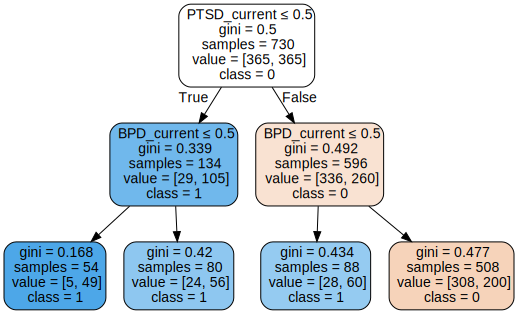

In [295]:
clf = tree.DecisionTreeClassifier(max_depth = 2)
clf1 = clf.fit(X1_balanced, y1_balanced)
dot_data = tree.export_graphviz(clf1, out_file=None, 
                      feature_na  mes=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['0','1','2','3+'], 
                      special_characters=True)
graph = graphviz.Source(dot_data)  
graph 


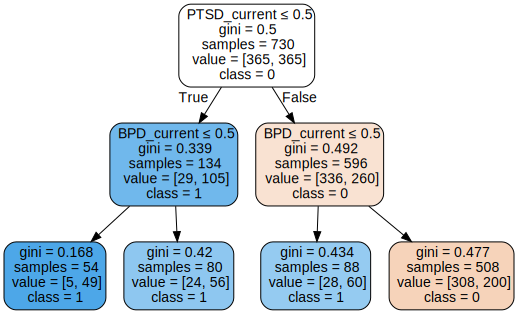

In [245]:
dot_data = tree.export_graphviz(clf1, out_file=None, 
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['0','1','2','3+'], 
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('../Results/sSui_cut.pdf')
graph 


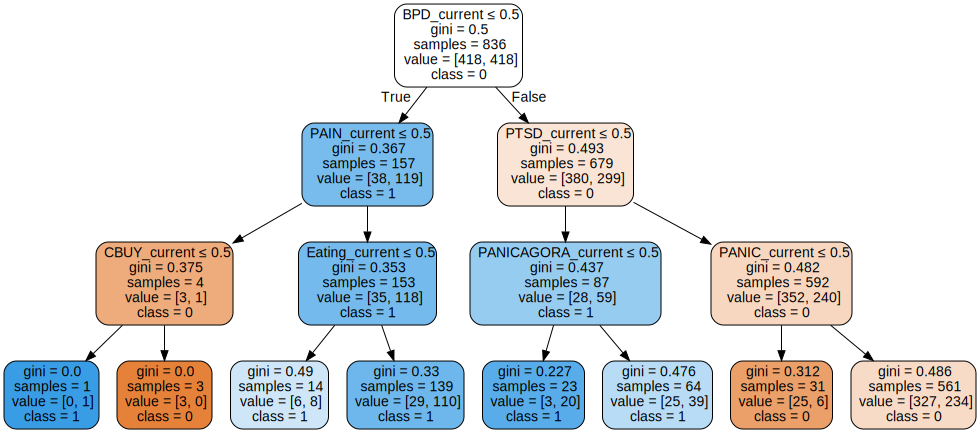

In [298]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf2 = clf.fit(X2_balanced, y2_balanced)
dot_data = tree.export_graphviz(clf2, out_file=None, 
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['0','1','2','3+'], 
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


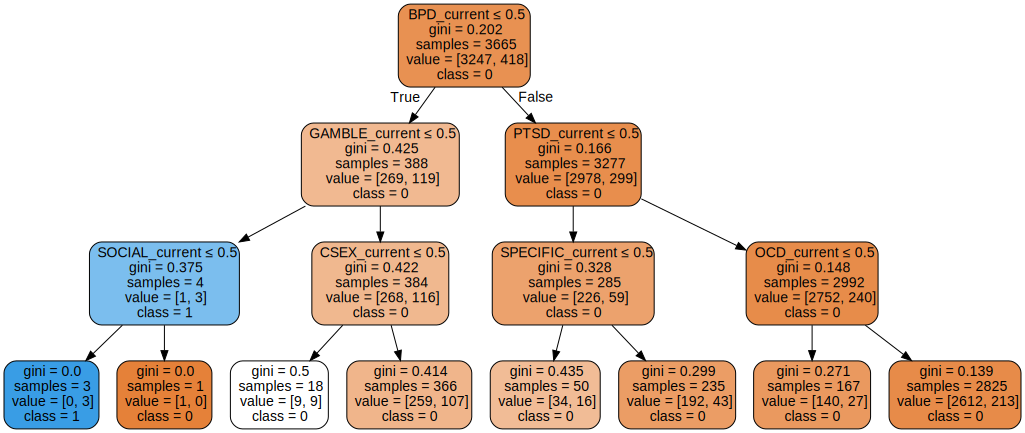

In [299]:
clf3 = clf.fit(X, y2)
dot_data = tree.export_graphviz(clf3, out_file=None, 
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['0','1','2','3+'], 
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [292]:
X, y = dfComp.filter(regex = 'curr')

0    3247
1     418
Name: nsSuiCutBi, dtype: int64

In [316]:
df4TreeCompSui = df4TreeComp[df4TreeComp.sSui != 0]
df4TreeCompSui['sSuiCut'] = pd.cut(df4TreeCompSui.sSui, [0,1,2,99])
df4TreeCompSui['sSuiCut'] = df4TreeCompSui['sSuiCut'].cat.rename_categories(['1','2','3+'])

In [320]:
XSui, ySui = df4TreeCompSui.filter(regex = 'curr'), df4TreeCompSui['sSuiCut']
XSui_oversampled, ySui_oversampled = resample(XSui[ySui == '2'],ySui[ySui == '2'],replace=True,
         n_samples=XSui[ySui == '1'].shape[0], random_state = 123)
XSui_oversampled2, ySui_oversampled2 = resample(XSui[ySui == '3+'],ySui[ySui == '3+'],replace=True,
         n_samples=XSui[ySui == '1'].shape[0], random_state = 123)


XSui_balanced = np.vstack((XSui[ySui == '1'], XSui_oversampled, XSui_oversampled2))
ySui_balanced = np.hstack((ySui[ySui == '1'], ySui_oversampled, ySui_oversampled2))

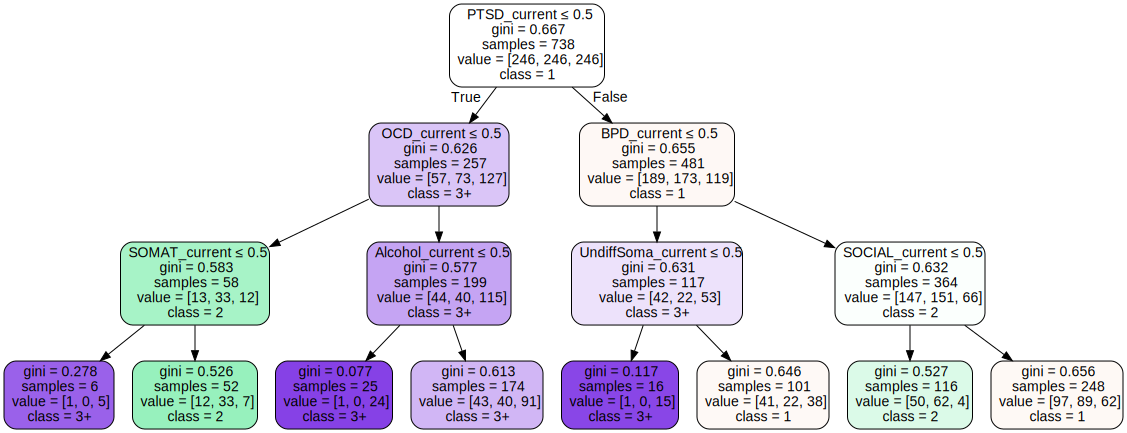

In [321]:

clf4 = clf.fit(XSui_balanced, ySui_balanced)
dot_data = tree.export_graphviz(clf4, out_file=None, 
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['1','2','3+'], 
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [324]:
 df4TreeComp.filter(regex='curr')

,BPD_current,MDD_current,DYSTH_current,BP1_current,BP2_current,PANIC_current,PANICAGORA_current,AGORA_current,GAD_current,SOCIAL_current,...,BINGE_current,SCHIZO_current,SCHIZOAFF_current,DELUS_current,Adjustment_current,BDD_current,SCHIZOFORM_current,BRIEF_current,Psychosis_current,Eating_current
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3670,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3671,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3672,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [351]:
df4TreeComp['Sui'] = df4TreeComp['nsSui'] + df4TreeComp['sSui']
df4TreeComp['Sui'].value_counts()

0.0     2989
1.0      398
2.0      126
3.0       63
4.0       31
5.0       17
7.0        7
8.0        5
6.0        5
10.0       4
9.0        4
20.0       3
12.0       3
17.0       2
14.0       2
15.0       1
45.0       1
48.0       1
16.0       1
18.0       1
13.0       1
Name: Sui, dtype: int64

In [345]:
df4TreeComp['SuiCut'] = pd.cut(df4TreeComp.Sui, [-1,0,2,99])
df4TreeComp['SuiCut'] = df4TreeComp['SuiCut'].cat.rename_categories(['0','1-2','3+'])
df4TreeComp.SuiCut.value_counts()

0      2989
1-2     524
3+      152
Name: SuiCut, dtype: int64

,Sui,Dx,profile
0,0.0,BPD_current,1.0
1,0.0,BPD_current,1.0
2,2.0,BPD_current,1.0
3,0.0,BPD_current,1.0
4,1.0,BPD_current,0.0
...,...,...,...
142930,0.0,Eating_current,1.0
142931,1.0,Eating_current,1.0
142932,0.0,Eating_current,1.0
142933,0.0,Eating_current,1.0


In [346]:

XCut, yCut = df4TreeComp.filter(regex='curr'), df4TreeComp['SuiCut']

XCut_oversampled, yCut_oversampled = resample(X[yCut == '1-2'],yCut[yCut == '1-2'],replace=True,
         n_samples=XCut[yCut == '0'].shape[0], random_state = 123)
XCut_oversampled2, yCut_oversampled2 = resample(X[yCut == '3+'],yCut[yCut == '3+'],replace=True,
         n_samples=XCut[yCut == '0'].shape[0], random_state = 123)
#XCut_oversampled3, yCut_oversampled3 = resample(X[yCut == '3+'],yCut[yCut == '3+'],replace=True,
#         n_samples=XCut[yCut == '0'].shape[0], random_state = 123)


XCut_balanced = np.vstack((XCut[yCut == '0'], XCut_oversampled, XCut_oversampled2, XCut_oversampled3))
yCut_balanced = np.hstack((yCut[yCut == '0'], yCut_oversampled, yCut_oversampled2, yCut_oversampled3))

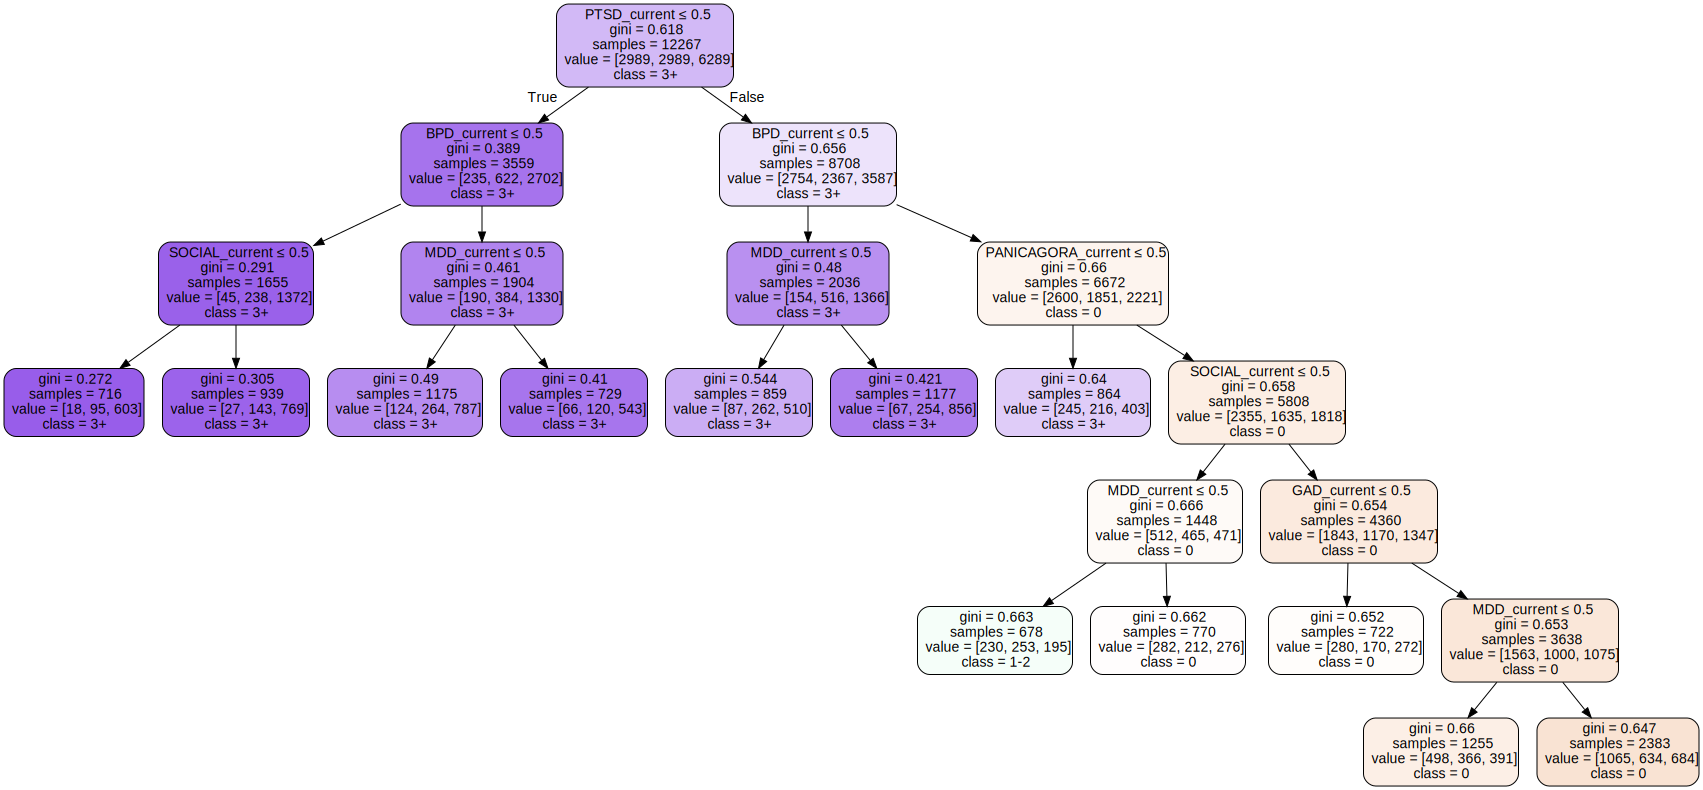

In [349]:
clf = tree.DecisionTreeClassifier(min_weight_fraction_leaf=0.05)
clf5 = clf.fit(XCut_balanced, yCut_balanced)
dot_data = tree.export_graphviz(clf5, out_file=None, 
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True, 
                      class_names= ['0','1-2','3+'], 
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


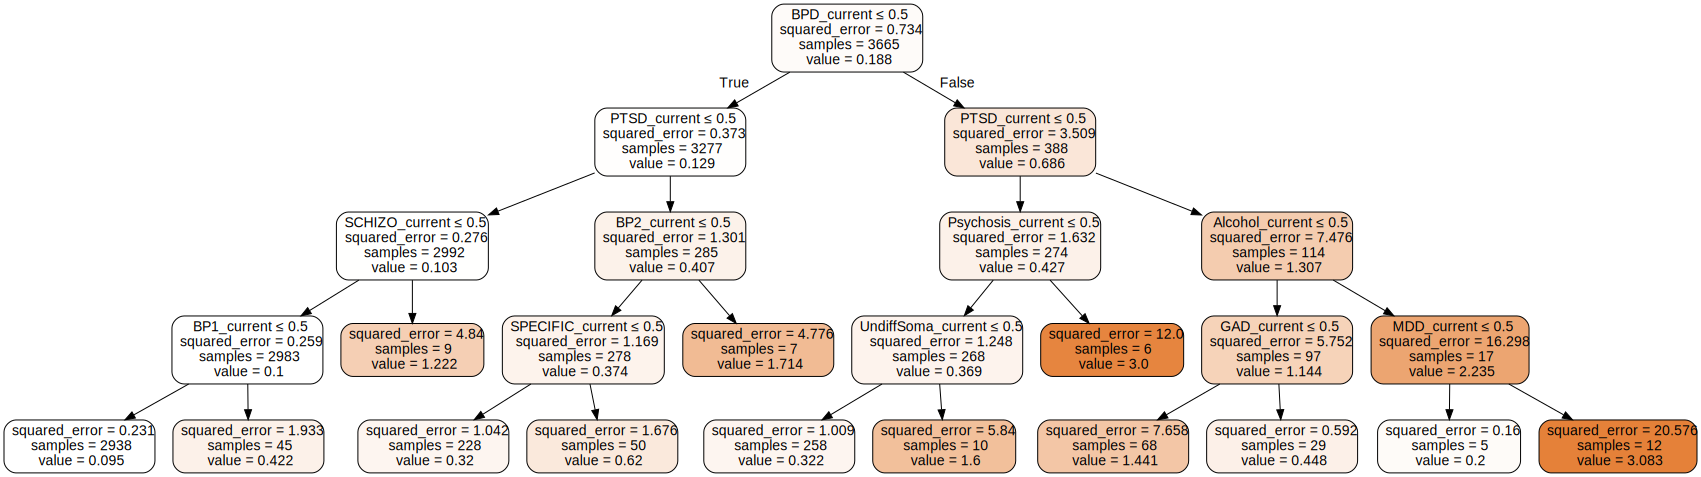

In [458]:
X, y = df4TreeComp.filter(regex='current'), df4TreeComp.sSui
clf = tree.DecisionTreeRegressor(min_weight_fraction_leaf = 0.001, max_depth=4)
clf5 = clf.fit(X, y)
dot_data = tree.export_graphviz(clf5,  
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True,
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [459]:
graph.render('../Results/treeReg')

'../Results/treeReg.pdf'

In [465]:
print(
'Past Serious SA >= 3, BPD incidence rate', df4TreeComp.loc[df4TreeComp.sSui >=3, 'BPD_current'].mean(),'\n', 
'Past Serious SA == 2, BPD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==2, 'BPD_current'].mean(),'\n',
'Past Serious SA == 1, BPD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==1, 'BPD_current'].mean(),'\n',
'Past Serious SA == 0, BPD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==0, 'BPD_current'].mean())

Past Serious SA >= 3, BPD incidence rate 0.47368421052631576 
 Past Serious SA == 2, BPD incidence rate 0.22580645161290322 
 Past Serious SA == 1, BPD incidence rate 0.2764227642276423 
 Past Serious SA == 0, BPD incidence rate 0.08454545454545455


In [466]:
print(
'Past Serious SA >= 3, PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui >=3, 'PTSD_current'].mean(),'\n', 
'Past Serious SA == 2, PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==2, 'PTSD_current'].mean(),'\n',
'Past Serious SA == 1, PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==1, 'PTSD_current'].mean(),'\n',
'Past Serious SA == 0, PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==0, 'PTSD_current'].mean())

Past Serious SA >= 3, PTSD incidence rate 0.5087719298245614 
 Past Serious SA == 2, PTSD incidence rate 0.3064516129032258 
 Past Serious SA == 1, PTSD incidence rate 0.23170731707317074 
 Past Serious SA == 0, PTSD incidence rate 0.0890909090909091


In [480]:
df4TreeComp.PTSD_current.iloc[i] == 1 and df4TreeComp.BPD_current.iloc[i] == 1

False

In [487]:
BPD_PTSD = []
BPD_nPTSD = []
nBPD_PTSD = []

for i in range(df4TreeComp.shape[0]):
    if (df4TreeComp.BPD_current.iloc[i] == 1 and df4TreeComp.PTSD_current.iloc[i] == 1):
        BPD_PTSD.append(1)
    else:
        BPD_PTSD.append(0)
    if(df4TreeComp.BPD_current.iloc[i] == 0 and df4TreeComp.PTSD_current.iloc[i] == 1):
        nBPD_PTSD.append(1)
    else:
        nBPD_PTSD.append(0)
        
    if(df4TreeComp.BPD_current.iloc[i] == 1 and df4TreeComp.PTSD_current.iloc[i] == 0):
        BPD_nPTSD.append(1)
    else:
        BPD_nPTSD.append(0)
        
        
df4TreeComp['BPD_PTSD'] = BPD_PTSD
df4TreeComp['nBPD_PTSD'] = nBPD_PTSD
df4TreeComp['BPD_nPTSD'] = BPD_nPTSD

In [486]:
print(
'Past Serious SA >= 3, BPD & PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui >=3, 'BPD_PTSD'].mean(),'\n', 
'Past Serious SA == 2, BPD & PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==2, 'BPD_PTSD'].mean(),'\n',
'Past Serious SA == 1, BPD & PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==1, 'BPD_PTSD'].mean(),'\n',
'Past Serious SA == 0, BPD & PTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==0, 'BPD_PTSD'].mean())

Past Serious SA >= 3, BPD & PTSD incidence rate 0.2631578947368421 
 Past Serious SA == 2, BPD & PTSD incidence rate 0.12903225806451613 
 Past Serious SA == 1, BPD & PTSD incidence rate 0.10569105691056911 
 Past Serious SA == 0, BPD & PTSD incidence rate 0.019696969696969695


In [499]:
(df4TreeComp >> group_by(X.sSui) >> summarise(BPD_nPTSD = mean(X.BPD_PTSD)))


,sSui,BPD_nPTSD
0,0.0,0.019697
1,1.0,0.105691
2,2.0,0.129032
3,3.0,0.142857
4,4.0,0.428571
5,5.0,0.000000
6,6.0,0.500000
7,7.0,0.000000
8,8.0,0.400000
9,9.0,0.500000


In [498]:
(df4TreeComp >> group_by(X.sSui) >> summarise(BPD_nPTSD = mean(X.nBPD_PTSD)))

#print(
#'Past Serious SA >= 3, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui >=3, 'BPD_nPTSD'].mean(),'\n', 
#'Past Serious SA == 2, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==2, 'BPD_nPTSD'].mean(),'\n',
#'Past Serious SA == 1, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==1, 'BPD_nPTSD'].mean(),'\n',
#'Past Serious SA == 0, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==0, 'BPD_nPTSD'].mean())

,sSui,BPD_nPTSD
0,0.0,0.069394
1,1.0,0.126016
2,2.0,0.177419
3,3.0,0.333333
4,4.0,0.142857
5,5.0,0.571429
6,6.0,0.000000
7,7.0,0.000000
8,8.0,0.200000
9,9.0,0.000000


In [497]:
(df4TreeComp >> group_by(X.sSui) >> summarise(BPD_nPTSD = mean(X.BPD_nPTSD)))

#print(
#'Past Serious SA >= 3, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui >=3, 'BPD_nPTSD'].mean(),'\n', 
#'Past Serious SA == 2, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==2, 'BPD_nPTSD'].mean(),'\n',
#'Past Serious SA == 1, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==1, 'BPD_nPTSD'].mean(),'\n',
#'Past Serious SA == 0, BPD & nPTSD incidence rate', df4TreeComp.loc[df4TreeComp.sSui ==0, 'BPD_nPTSD'].mean())

,sSui,BPD_nPTSD
0,0.0,0.064848
1,1.0,0.170732
2,2.0,0.096774
3,3.0,0.238095
4,4.0,0.285714
5,5.0,0.142857
6,6.0,0.250000
7,7.0,0.333333
8,8.0,0.000000
9,9.0,0.000000
